<a href="https://colab.research.google.com/github/NoemiTagliavacche/ML_course_Pavia_23/blob/main/KCNodeClassificationPyG_optionalExsercise_GANConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install torch geometric
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy()) #dimensionality reduction of data, I obtain data in 2 D dimension in a way to visualize it

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid #dataset
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) #NormalizeFeatures= scale features to normalize it

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        self.conv3 = GCNConv()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16) #16 is the size of the hidden representation of the layer (is the size of the h function)
print(model)

In [20]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        # TODO
        self.conv1=GATConv(dataset.num_features,hidden_channels,heads,dropout=0.6) # heads? 
        self.conv2=GATConv(hidden_channels*heads,dataset.num_classes,heads=1,dropout=0.6)# nella GATConv di default uso Leaky ReLU come activation function

#per capire meglio che succede:
#se ho una sola head ricavo una sola matrice alpha perchè uso un solo MLP per tutte le features.
#con heads=8 voglio imparare 8 diverse matrici alpha e uso per questo 8 MLP diversi. 
#di conseguenza la size finale in uscit alla prima conv sarà hidden_channels*heads=8*8=64
#devo quindi avere la stessa size in ingresso al conv2 per questo metto hidden_channel*heads

    def forward(self, x, edge_index):
        # TODO
        x = self.conv1(x, edge_index)
        x = x.relu() # questa activation function è quella per calcolare hi(l+1) dati alpha e zi(l)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

loss_train= []
acc_val, acc_test = [],[]

epoch=len(range(1, 201))

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    loss_train.append(loss.detach().numpy()) #questo comando serve perchè all'interno di loss c'è anche il gradiente, gli sto dicendo di dimenticarsi del gradiente e appendermi solo il valore numerico della loss function
    acc_test.append(test_acc)
    acc_val.append(val_acc)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9451, Val: 0.2220, Test: 0.2160
Epoch: 002, Loss: 1.9401, Val: 0.1980, Test: 0.2080
Epoch: 003, Loss: 1.9363, Val: 0.2820, Test: 0.2910
Epoch: 004, Loss: 1.9323, Val: 0.6760, Test: 0.7250
Epoch: 005, Loss: 1.9264, Val: 0.7460, Test: 0.7710
Epoch: 006, Loss: 1.9174, Val: 0.7020, Test: 0.7330
Epoch: 007, Loss: 1.9131, Val: 0.6840, Test: 0.7150
Epoch: 008, Loss: 1.9138, Val: 0.6740, Test: 0.7140
Epoch: 009, Loss: 1.9043, Val: 0.6660, Test: 0.7040
Epoch: 010, Loss: 1.8976, Val: 0.6720, Test: 0.7130
Epoch: 011, Loss: 1.8832, Val: 0.6900, Test: 0.7300
Epoch: 012, Loss: 1.8805, Val: 0.7220, Test: 0.7490
Epoch: 013, Loss: 1.8749, Val: 0.7520, Test: 0.7720
Epoch: 014, Loss: 1.8550, Val: 0.7780, Test: 0.7770
Epoch: 015, Loss: 1.8419, Val: 0.7800, Test: 0.7720
Epoch: 016, Loss: 1.8408, Val: 0.7740, Test: 0.7770
Epoch: 017, Loss: 1.8370, Val: 0.7720, Test: 0.7750
Epoch: 018, Loss: 1.8319, Val: 0.7700

In [21]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(1,201))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train,label='Training ')
  
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_test,label='Test ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()

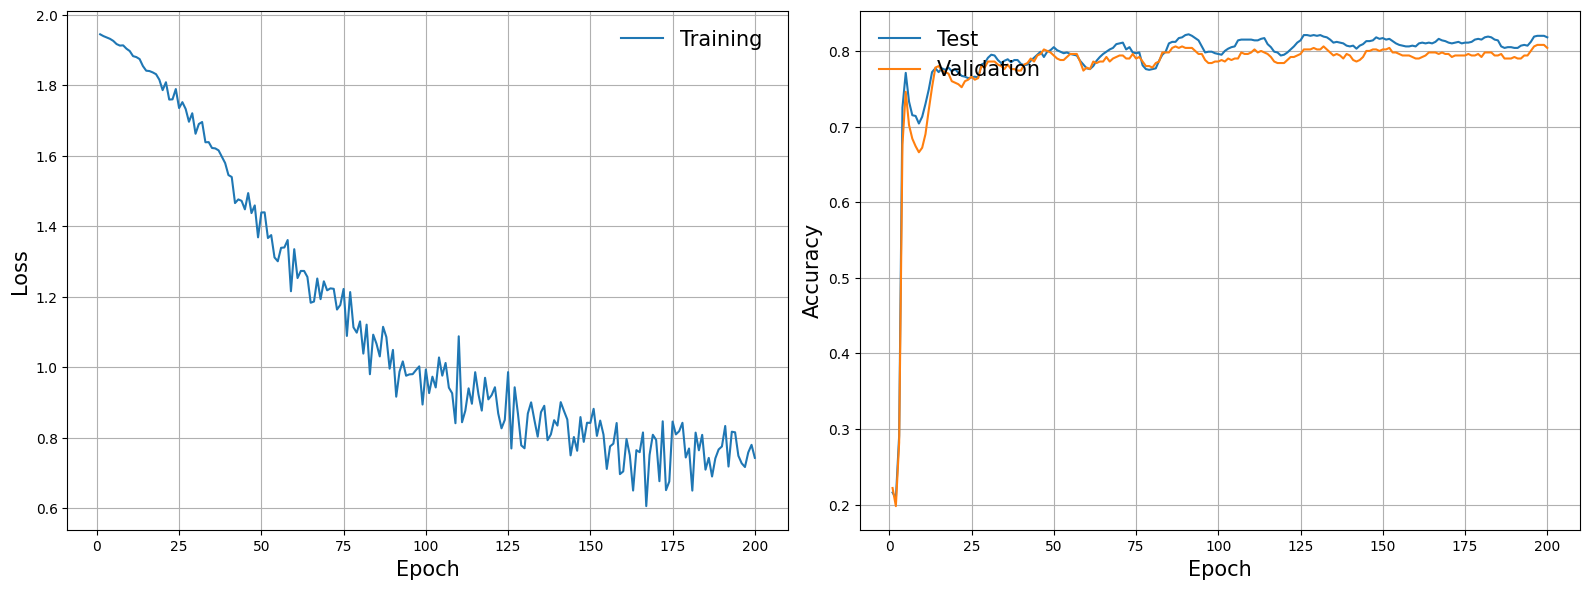

In [22]:
draw_metric_evolution()